# 2次元混合ガウス + ノイズ後サンプル可視化

このノートブックでは、下記の手順で可視化を行います。

1. **2次元混合ガウス分布**を用意
2. **100個サンプリング**して元の訓練データとする
3. **各サンプルに対してガウスノイズを100個**ずつ付加 (計10,000サンプル)
   - このとき、ノイズ後サンプルと元の点との対応関係を保持
4. **ノイズ後データ空間で特定のピクセル(矩形領域)を指定**し、
   そこに含まれるノイズ後サンプルが元々どの点に対応しているかを
   密度(ヒートマップ)で表示


## 1. ライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


## 2. 2次元混合ガウス分布の定義とサンプリング関数

In [2]:
def sample_mixture_gaussians(num_samples, mixing_coeffs, means, covs):
    """\n
    指定された混合ガウス分布から num_samples 個のサンプルを生成して返す関数\n
    mixing_coeffs: 混合係数のリスト (例: [0.5, 0.5])\n
    means: 各成分ガウスの平均リスト (例: [mean1, mean2])\n
    covs: 各成分ガウスの共分散行列リスト (例: [cov1, cov2])\n
    """
    samples = []
    n_components = len(mixing_coeffs)
    # どのコンポーネントからサンプリングするかを確率的に決定
    component_indices = np.random.choice(
        n_components, size=num_samples, p=mixing_coeffs
    )
    for c in component_indices:
        m = means[c]
        c_ = covs[c]
        s = np.random.multivariate_normal(m, c_, 1)
        samples.append(s)
    return np.vstack(samples)


### 混合ガウス分布のパラメータ設定 & サンプル生成

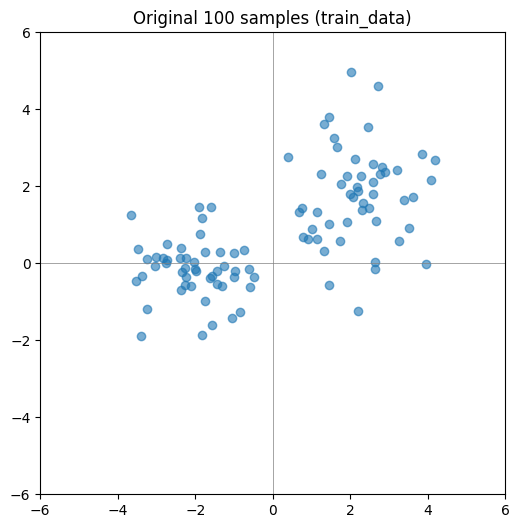

train_data.shape = (100, 2)


In [3]:
np.random.seed(123)

# 混合ガウスのパラメータ定義
mixing_coeffs = [0.5, 0.5]
means = [np.array([-2.0, 0.0]), np.array([2.0, 2.0])]
covs = [np.array([[1.0, 0.0], [0.0, 1.0]]), np.array([[1.0, 0.0], [0.0, 1.0]])]

# 訓練データとして100点をサンプリング
num_train = 100
train_data = sample_mixture_gaussians(num_train, mixing_coeffs, means, covs)

# 散布図で表示
plt.figure(figsize=(6, 6))
plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.6)
plt.title("Original 100 samples (train_data)")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.show()

print("train_data.shape =", train_data.shape)

## 3. ノイズを付加してノイズ後データを生成

各元データ点に対して正規分布ノイズを 100個足す → 合計 10,000サンプル。

In [4]:
# ノイズの標準偏差
sigma = 0.8
# 各訓練データに対して作るノイズ後サンプル数
num_noisy_per_point = 100

all_noisy_data = []
all_noisy_source_index = []  # 派生元(どの train_data[i] から生成されたか)を記録

for i in range(num_train):
    x0 = train_data[i]
    # 2Dのガウスノイズを100個生成
    noise = np.random.randn(num_noisy_per_point, 2) * sigma
    # ノイズを加えたサンプル
    noisy_points = x0 + noise

    all_noisy_data.append(noisy_points)
    # どの元データ点(i番目)から派生したかを同じ個数だけ記録
    all_noisy_source_index.append(np.full(num_noisy_per_point, i))

all_noisy_data = np.vstack(all_noisy_data)  # shape: (10000, 2)
all_noisy_source_index = np.hstack(all_noisy_source_index)  # shape: (10000,)

print("Noisy data shape:", all_noisy_data.shape)
print("Source index shape:", all_noisy_source_index.shape)

Noisy data shape: (10000, 2)
Source index shape: (10000,)


ノイズ後データ全体の散布図を軽く確認してみましょう。

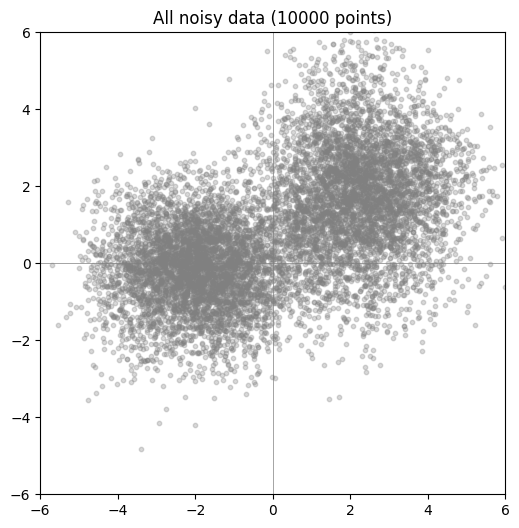

In [49]:
plt.figure(figsize=(6, 6))
plt.scatter(all_noisy_data[:, 0], all_noisy_data[:, 1], c="gray", alpha=0.3, s=10)
plt.title("All noisy data (10000 points)")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.show()

## 4. ノイズ後の空間の「特定のピクセル(領域)」とその元データの可視化


In [58]:
def plot_region_and_sources(
    x_center=0.0,
    y_center=0.0,
):
    """
    指定された (x_center, y_center) を中心とした
    幅width, 高さheight の矩形領域に含まれるノイズ後サンプル (noisy_in_pixel) を
    濃い色でプロットし、
    さらにそれらのサンプルが元の空間のどこから来たか (pixel_source_points) を赤色で描画する。

    また、全ノイズ後データ (all_noisy_data) は薄い色で表示する。
    """
    width = 0.5
    height = 0.5
    xmin = x_center - width / 2
    xmax = x_center + width / 2
    ymin = y_center - height / 2
    ymax = y_center + height / 2

    # --- 矩形領域に入るサンプルを抽出 ---
    in_pixel_mask = (
        (all_noisy_data[:, 0] >= xmin)
        & (all_noisy_data[:, 0] < xmax)
        & (all_noisy_data[:, 1] >= ymin)
        & (all_noisy_data[:, 1] < ymax)
    )
    idx_in = np.where(in_pixel_mask)[0]

    # 矩形内にあるノイズ後サンプル
    noisy_in_pixel = all_noisy_data[idx_in]

    # そのノイズ後サンプルの「元データインデックス」と「元座標」
    pixel_sources = all_noisy_source_index[idx_in]
    pixel_source_points = train_data[pixel_sources]

    # --- プロット ---
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1. 全ノイズ後データ(薄い色)
    ax.scatter(
        all_noisy_data[:, 0],
        all_noisy_data[:, 1],
        color="lightgray",
        alpha=0.25,
        s=10,
        label="All noisy data",
    )

    # 2. 矩形に入っているノイズ後データ(濃い色)
    ax.scatter(
        noisy_in_pixel[:, 0],
        noisy_in_pixel[:, 1],
        color="blue",
        alpha=0.8,
        s=10,
        label="Noisy data in region",
    )

    # 3. 全訓練データ(元データ)
    ax.scatter(
        train_data[:, 0],
        train_data[:, 1],
        color="gray",
        alpha=1.0,
        s=20,
        label="All train_data",
    )

    # 4. 矩形内のノイズの元データ点(赤)
    ax.scatter(
        pixel_source_points[:, 0],
        pixel_source_points[:, 1],
        color="magenta",
        alpha=0.25,
        s=20,
        label="Sources in region",
    )

    # 5. 矩形領域の描画
    rect_x = [xmin, xmax, xmax, xmin, xmin]
    rect_y = [ymin, ymin, ymax, ymax, ymin]
    ax.plot(rect_x, rect_y, color="black", linestyle="--", label="Selected Region")

    ax.set_title(
        f"Noisy region => {len(idx_in)} samples\n"
        f"Red: {len(pixel_source_points)} sources"
    )
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.legend()
    plt.show()


In [59]:
# スライダーの設定
x_center_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description="x_center",
    continuous_update=True,
)
y_center_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description="y_center",
    continuous_update=True,
)

interactive_obj = widgets.interactive(
    plot_region_and_sources,
    x_center=x_center_slider,
    y_center=y_center_slider,
)


In [60]:
display(interactive_obj)

interactive(children=(FloatSlider(value=0.0, description='x_center', max=5.0, min=-5.0), FloatSlider(value=0.0…

一部例示

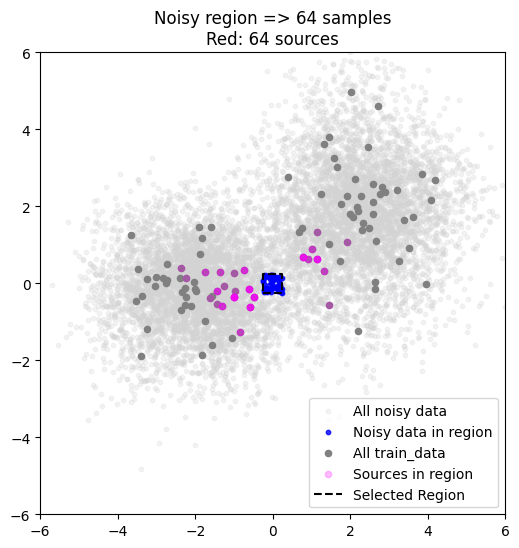

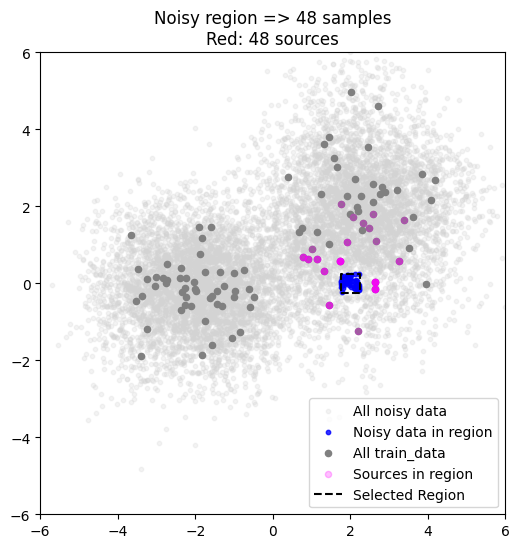

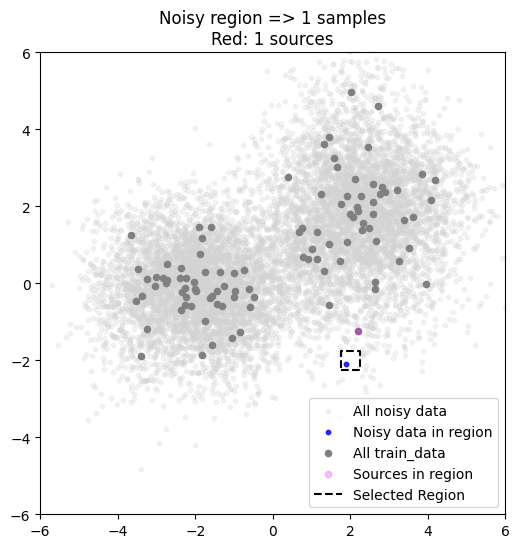

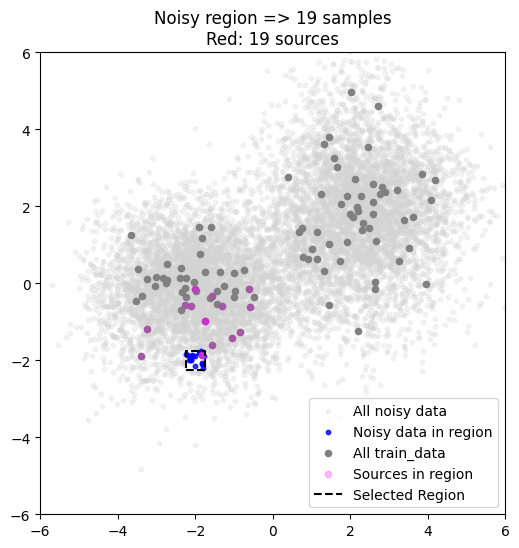

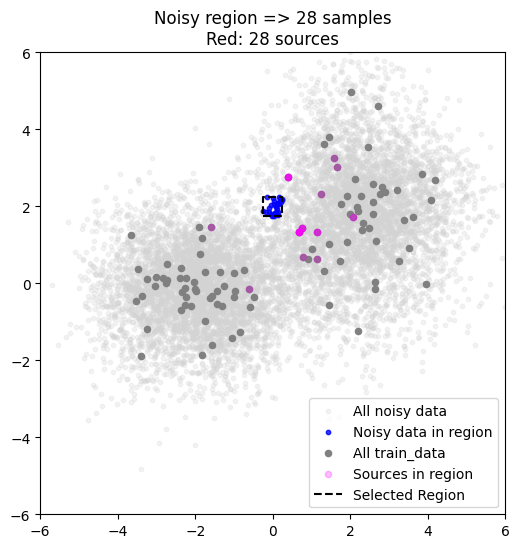

In [66]:
plot_region_and_sources(0.0, 0.0)
plot_region_and_sources(2.0, 0.0)
plot_region_and_sources(2.0, -2.0)
plot_region_and_sources(-2.0, -2.0)
plot_region_and_sources(0.0, 2.0)
